# 0. Introduction of K2, AGN, and time series
## III. Effect of missing data on the PSD

M. Gully-Santiago  
Summer 2019  
Kepler/K2 GO Office

What is the effect of gaps or missing data on the PSD?

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import lightkurve as lk

# What does the real data look like in a PSD?

First let's get genuine data to simulate its properties as close as we can.

In [3]:
tpf = lk.search_targetpixelfile('EPIC 211991001', mission='K2', cadence='long', campaign=5).download()

In [4]:
lc = tpf.to_lightcurve()

#### What do do about non-uniform time sampling?

In [5]:
t_gaps = ((lc.time[1:] - lc.time[0:-1])*u.day).to(u.hour)

In [6]:
np.max(t_gaps)

<Quantity 1.96146661 h>

The largest gap is four consecutive 30-minute cadences.

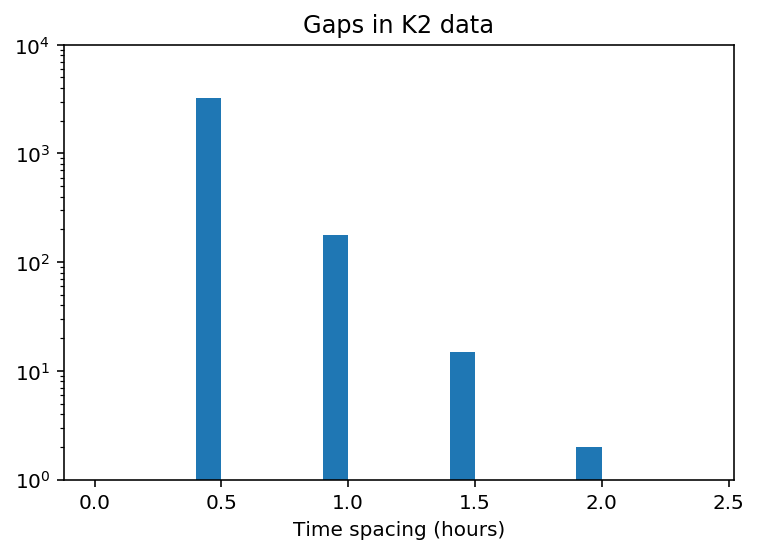

In [7]:
plt.hist(t_gaps.value, bins=np.arange(0, 2.5, 0.1));
plt.yscale('log')
plt.xlabel('Time spacing (hours)')
plt.title("Gaps in K2 data")
plt.ylim(1e0, 1e4);

We *do not* have evenly spaced frequencies, so we technically shouldn't use the numpy implementation of FFT from the celerite example.  Instead we should use the `NFFT` algorithm:
https://github.com/jakevdp/nfft  
This algorithm requires some extra preprocessing and tuning, so I will leave that as an exercise for the future, or as a feature addition to `lightkurve`.

We can also "fill gaps".  The problem with "filling gaps" is that the inserted data may alter the Power Spectral Density slope in a way that may be difficult to quantify or detect...  

In [8]:
import celerite
from celerite import terms

In [9]:
def generate_fake_signal(t_in, mean_flux):
    t = (t_in*u.day).to(u.second).value
    
    t_char = (0.3*u.year).to(u.second)
    c_val = 2.0*np.pi * 1/(t_char) # units of Hertz
    a_val = c_val*9e12

    true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)
    kernel = terms.RealTerm(log_a=true_loga, log_c=true_logc) 
    gp = celerite.GP(kernel, mean=mean_flux)
    gp.compute(t)
    y = gp.sample()
    return y

In [10]:
t_step = lc.time[1] - lc.time[0]
t_step*24*60 #minutes

29.42249152692966

In [11]:
regularly_sampled_time = np.arange(lc.time[0], lc.time[-1], t_step)

In [12]:
nn = len(regularly_sampled_time)

In [13]:
fake_cadenceno = np.arange(lc.cadenceno[0], lc.cadenceno[0]+nn, 1)

In [14]:
lc_fake = lk.LightCurve(time=regularly_sampled_time, 
                        flux=generate_fake_signal(regularly_sampled_time, lc.flux.mean()))

In [15]:
mask = np.in1d(fake_cadenceno, lc.cadenceno)

In [16]:
lc_fake[mask].flux.shape

(3449,)

/Users/obsidian/anaconda3/envs/probabilisticAGN/lib/python3.6/site-packages/lightkurve/periodogram.py:752: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)


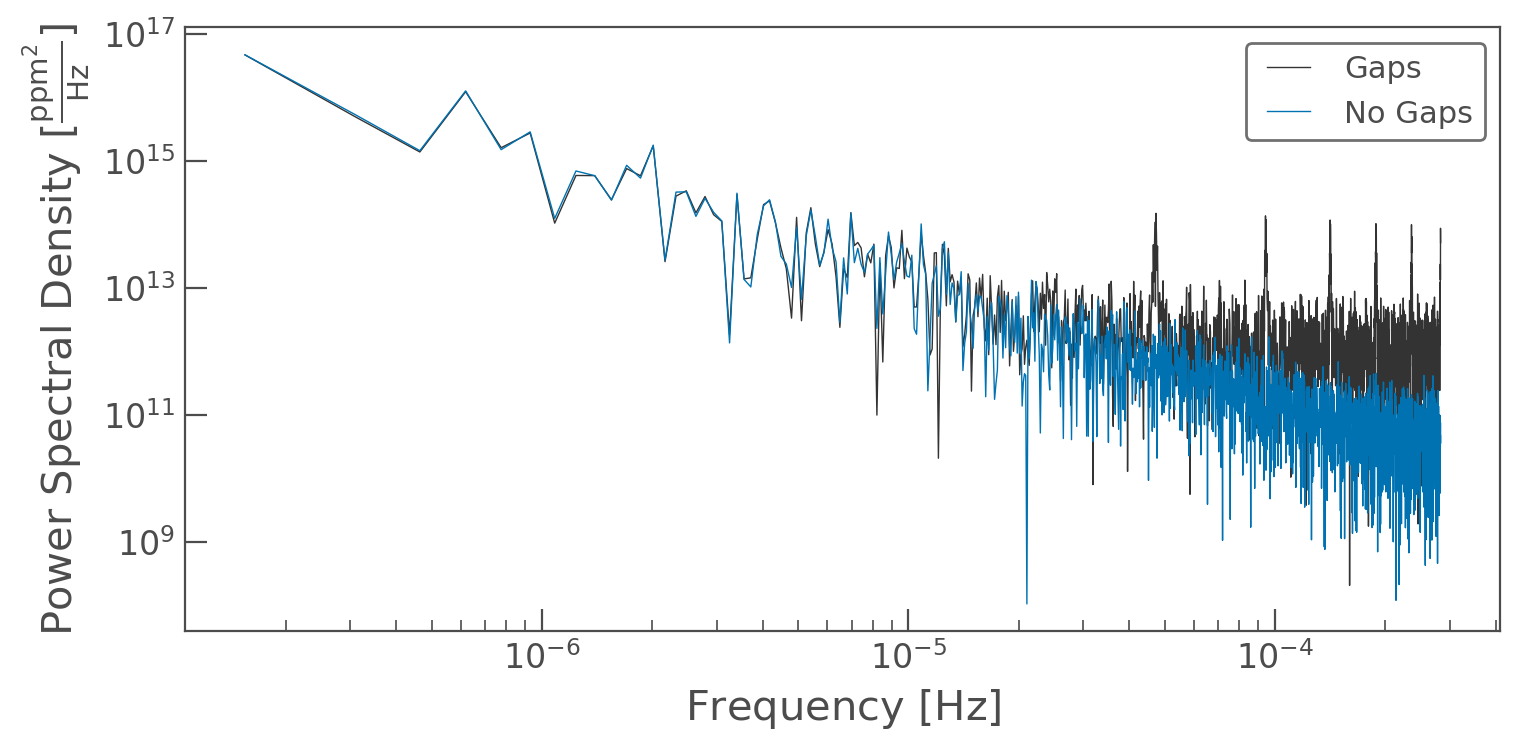

In [17]:
pg1 = lc_fake.to_periodogram(freq_unit=u.Hz, normalization='psd')
pg2 = lc_fake[mask].to_periodogram(freq_unit=u.Hz, normalization='psd')
ax = pg2.plot(scale='log', label='Gaps')
pg1.plot(scale='log', label='No Gaps', ax=ax);

The gaps have semi-regular spacing, so we get aliased power on those scales from over-fitting noise spikes.